# TO DO

1) Add another check for the collision since now we are introducing a robot and not more a rigid material point moving in the plane

2) In the steer function add the trajectory controller taking in account the dynamics of the robot and the fact that the robot is controlled in velocity

3) Decied how to do the feedback

# CODE

In [ ]:
#!pip install seaborn

In [1]:
import numpy as np
import math
from env import *
from plotting import *
import copy
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = None


class RRT_STAR:
    def __init__(self, start, goal, env, step, prob_gs, n_iters):

        self.node_s = Node(start[0], start[1])
        self.node_g = Node(goal[0], goal[1])
        self.env = env
        self.n_iters = n_iters
        # CHECK IF START NODE AND GOAL NODE IN THE ENV......
        self.step = step
        self.prob_gs = prob_gs  # Empirical value
        self.utils = Utils()
        self.node_s.cost = 0
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g)
        # Empirical value
        self.radius = max(self.env.x_range[-1], self.env.y_range[-1])//10
        self.trav_map = np.clip(np.random.normal(3, 8, size=(50, 30)), 2, 100)
        self.max_vel = max_vel
        self.mass = mass
        self.a = a
        self.b = b
        self.mu = mu
        self.fr = fr
        self.Iz = Iz
        self.g = g
        self.d0 = d0
        self.r = r
        self.tau_max = tau_max
        self.t = t
        self.kv = kv
        self.kp = kp
        self.ka = ka

        ##### initial state ###
        self.xd = xd
        self.yd = yd
        self.thetad = thetad
        self.xdd = xdd
        self.ydd = ydd
        self.thetadd = thetadd

    def planning(self):
        # ax = sns.heatmap(self.trav_map.T, linewidth=0.5)
        # plt.show()
        for iter in range(self.n_iters):

            if iter % 500 == 0:
                print(iter)

            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)
            if not self.utils.is_collision(n_nearest, n_new):

                # n_new, T = self.steer(n_nearest, n_new, self.xd, self.yd,
                #                       self.thetad, self.xdd, self.ydd, self.thetadd)

                # FUNCTION thath computes new position, velocity and acceleration of the robot

                N_near = self.compute_NN(n_new, near=True)
                n_min, cost_min = self.choose_parent(N_near, n_nearest, n_new)
                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                self.rewire(N_near, n_min, n_new)
        path = [[self.node_g.x, self.node_g.y]]
        goal_state = self.get_goal_state()

        tot_path = self.compute_path(path, goal_state)

        self.plotting.animation(self.Tree, tot_path,
                                "rrt*, N = " + str(self.n_iters))

    def choose_parent(self, N_near, n_nearest, n_new):
        n_parent = n_nearest
        # Init. guess parent for sampled node
        cost_min = n_nearest.cost + self.compute_cost(n_nearest, n_new)

        for n_near in N_near:
            # Compute Trajectory control HERE!!!
            # Collision CHECK!!!
            if not self.utils.is_collision(n_near, n_new):
                # n_new, T = self.steer(n_near, n_new, self.xd, self.yd,
                #                       self.thetad, self.xdd, self.ydd, self.thetadd)
                inter_cost = n_near.cost + \
                    self.compute_cost(n_near, n_new)  # Intermediate cost
                if n_new.cost != None:
                    if inter_cost < n_new.cost and inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost
                else:
                    if inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost

        return n_parent, cost_min

    def rewire(self, N_near, n_parent, n_new):

        for n_near in N_near:
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue
            # Steer!!!
            # Obstacle!!!
            if not self.utils.is_collision(n_near, n_new):
                # z_new, T = self.steer(n_near, n_new, self.xd, self.yd,
                #         self.thetad, self.xdd, self.ydd, self.thetadd)
                if n_new.cost + self.compute_cost(n_near, n_new) < n_near.cost:
                    # if z_new.x == n_new.x and z_new.y == n_new.y:
                    n_near_old_idx = self.Tree.index(n_near)
                    n_near.parent = n_new
                    n_near.cost = n_new.cost + self.compute_cost(n_near, n_new)
                    self.Tree[n_near_old_idx] = n_near
        return

    def compute_NN(self, n_curr, near=False):

        # CHECK COLLISION
        dist_list = np.array([self.compute_dist(n_curr, n_tree)
                             for n_tree in self.Tree])

        if not near:  # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)

            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)
            n_new = Node(n_nearest.x + dist*math.cos(theta),
                         n_nearest.y + dist*math.sin(theta))

            return n_nearest, n_new
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(
                len(dist_list)) if dist_list[idx] < self.radius]

            return node_list

    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:
            x_new = np.random.uniform(self.env.x_range[-1])
            y_new = np.random.uniform(self.env.y_range[-1])
            # print(x_new, y_new)
            return Node(x_new, y_new)

        return self.node_g

    def get_goal_state(self):

        dist_list = np.array([self.compute_dist(node, self.node_g)
                             for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]

        return goal_state

    def compute_path(self, path, goal_state):

        n_curr = goal_state
        while n_curr.x != self.node_s.x and n_curr.y != self.node_s.y:
            path.append([n_curr.x, n_curr.y])
            n_curr = n_curr.parent
        path.append([n_curr.x, n_curr.y])

        return path

    def compute_dist(self, n1, n2):
        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y-n2.y)**2)
        return dist

    def compute_cost(self, n1, n2):
        # Add Traversability!!!

        # Elevation on the real map
        n1_trav = self.trav_map[int(n1.x), int(n1.y)]
        n2_trav = self.trav_map[int(n2.x), int(n2.y)]

        increm = n2_trav - n1_trav  # Elevation between the two points
        plan_dist = self.compute_dist(n1, n2)  # Planar distance

        cost = math.sqrt(plan_dist**2 + increm**2)
        # cost = self.compute_dist(n1, n2)

        return cost

    def steer(self, n1, n2, xd, yd, thetad, xdd, ydd, thetadd):
        '''I will consider the motion of the center of mass of the 4wdd using Runge Kutta integration'''

        x = n1.x
        y = n1.y
        theta = math.atan2((n2.y - n1.y), (n2.x - n1.x))

        dist = self.compute_dist(n1, n2)

        # Ideally I want to go from n1 to n2 with the max velocity reachable by the robot
        T = dist/self.max_vel

        z1, z2, z1d, z2d, z1dd, z2dd, z1ddd, z2ddd = self.compute_trajectory(
            n1, n2, T)

        # The variable with the UNDERSCORE is the real one executed by the robot
        z1_, z2_, z1d_, z2d_, z1dd_, z2dd_ = self.compute_state(
            n1, n2, xd, yd, theta, xdd, ydd, thetad, thetadd, T)

        r1 = z1ddd + self.ka*(z1dd - z1dd_) + self.kv * \
            (z1d - z1d_) + self.kp*(z1 - z1_)
        r2 = z2ddd + self.ka*(z2dd - z2dd_) + self.kv * \
            (z2d - z2d_) + self.kp*(z2 - z2_)

        Rx, Fy, Mr = self.compute_friction(xd, yd, thetad)

        ########## u1 MISSING ##############
        eps_d = math.cos(theta)*r1 + math.sin(theta)*r2 + 1/self.d0*xd*yd**2
        u1 = 0.5  # eps
        ####################################
        u2 = self.d0/xd*(math.sin(theta)*r1 - math.cos(theta)*r2)-2/xd*u1*yd

        tau1 = self.r/2*(self.mass*u1 + self.mass/self.d0*yd**2+Rx)-self.r*self.d0/(
            2*self.t)*((self.mass+self.Iz/self.d0**2)*u2-self.mass/self.d0*xd*yd+Fy-Mr/self.d0)
        tau2 = self.r/2*(self.mass*u1 + self.mass/self.d0*yd**2+Rx)+self.r*self.d0/(
            2*self.t)*((self.mass+self.Iz/self.d0**2)*u2-self.mass/self.d0*xd*yd+Fy-Mr/self.d0)

        if tau1 > self.tau_max or tau1 < - self.tau_max:
            tau1 = np.sign(tau1)*self.tau_max
        if tau2 > self.tau_max or tau2 < - self.tau_max:
            tau2 = np.sign(tau2)*self.tau_max

        v, w = self.compute_control(tau1, tau2, Rx, Fy, Mr, theta)

        xf, yf, thetaf = self.RK_integration(x, y, theta, T, v, w)
        n_new = Node(xf, yf)

        return n_new, T

    def RK_integration(self, x, y, theta, T, v, w):
        ''' Runge Kutta integration for a generic differential drive robot'''
        xf = x+v*T*math.cos(theta*(w*T)/2)
        yf = y+v*T*math.sin(theta*(w*T)/2)
        thetaf = theta+w*T

        return xf, yf, thetaf

    def compute_trajectory(self, n1, n2, T):
        ''' In this function I assume that the robot is moving in a straight line from a node to the next one'''
        z1 = np.poly1d([1, 0, 0, 0]) + n1.x  # third degree polynomial
        const = float((n2.y - n1.y)/(n2.x - n1.x)) # line equation
     
        z2 = n1.y + const*(z1 - n1.x)

        z1d = z1.deriv()
        z2d = const*z1d

        z1dd = z1d.deriv()
        z2dd = const*z1dd
 
        z1ddd = z1dd.deriv()
        z2ddd = const*z1ddd

        return z1(T), z2(T), z1d(T), z2d(T), z1dd(T), z2dd(T), z1ddd(T), z2ddd(T)

    def compute_friction(self, xd, yd, thetad):
        '''This function computes the resistive force on the x axis Rx, the viscous friction on the y axis Fy and the resistive moment Mr'''
        x1d = x4d = xd - self.t*thetad
        x3d = x2d = xd + self.t*thetad

        y1d = y2d = yd + self.a*thetad
 
        y3d = y4d = yd - self.b*thetad

        Rx = self.fr*(self.mass*self.g)/2 * (np.sign(x1d) + np.sign(x2d))
        Fy = self.mu*((self.mass*self.g)/(self.a + self.b)) * \
            (self.b*np.sign(y1d) + self.a*np.sign(y3d))
        Mr = self.mu*((self.a*self.b*self.mass*self.g)/(self.a + self.b))*(np.sign(y1d) -
                                                                           np.sign(y3d)) + self.fr*self.t*self.mass*self.g/2*(np.sign(x2d) - np.sign(x1d))
        return Rx, Fy, Mr

    def compute_control(self, tau1, tau2, Rx, Fy, Mr, theta):
        '''This function computes the commands v and w useful for the Runge Kutta integration '''
        M = np.array([[self.mass, 0, 0], [0, self.mass, 0], [0, 0, self.Iz]])
        c = np.array([[Rx*math.cos(theta)-Fy*math.sin(theta)],
                     [Rx*math.sin(theta)+Fy*math.cos(theta)],
                      [Mr]])
        E = np.array([[math.cos(theta)/self.r, math.cos(theta)/self.r],
                      [math.sin(theta)/self.r, math.sin(theta)/self.r],
                      [self.t/self.r, -self.t/self.r]])
        tau = np.array([[tau1], [tau2]])
        qdd = np.linalg.inv(M)@(E@tau - c)
        ##################################
        # qd ## second problem ##
        ##################################
        v = 0.3
        w = 0.1

        return v, w

    def compute_state(self, n1, n2, xd, yd, theta, xdd, ydd, thetad, thetadd, T):
        z1 = n1.x
        z2 = n1.y
        theta = math.atan2((n2.y - n1.y), (n2.x - n1.x))

        xd = (n2.x - n1.x)/T
        yd = (n2.y - n1.y)/T

        z1d_ = xd*math.cos(theta) - yd*math.sin(theta) - \
            self.d0*math.sin(theta)*thetad
        z2d_ = xd*math.sin(theta) + yd*math.cos(theta) + \
            self.d0*math.cos(theta)*thetad

        z1dd_ = xdd*math.cos(theta) - yd*thetad*math.sin(theta) - self.d0 * \
            math.cos(theta)*thetad**2 - self.d0*math.sin(theta)*thetadd
        z2dd_ = ydd*math.sin(theta) + xd*thetad*math.cos(theta) - self.d0 * \
            math.sin(theta)*thetad**2 + self.d0*math.cos(theta)*thetadd
        return z1, z2, z1d_, z2d_, z1dd_, z2dd_
    

In [7]:
start = 2, 2
goal = 45, 25
env = Env(x_bounds=x_bounds, y_bounds=y_bounds)

prob_gs = 0.1
n_iters = 2000
step = 10

rrt = RRT_STAR(start, goal, env, step, prob_gs, n_iters)

0
500
1000
1500


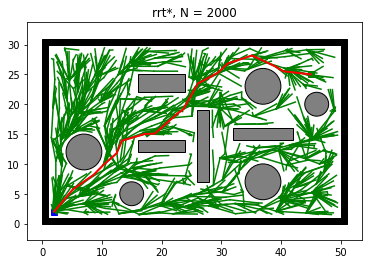

In [8]:
rrt.planning()

In [ ]:
N_near = [n_nearest, n1, n2]

In [8]:
def get_key(el):

    return el[0]

l = [(30, 1), (20, 2), (5, 4), (10,11)]
idx_min(l, key = get_key)


(5, 4)

In [ ]:
rrt.rewire(N_near, n1, n_new)

In [ ]:
rrt.Tree[1].cost

In [89]:
np.clip(np.random.normal(3, 1, size = (30, 50)), 0, 10)

array([[2.77952685, 2.34587721, 2.58542192, ..., 3.46067756, 2.41679018,
        4.44843464],
       [3.29843258, 2.9535215 , 2.71760168, ..., 2.38485116, 1.67587108,
        2.96043352],
       [2.10235456, 2.63892518, 1.38002193, ..., 3.76144618, 0.69321575,
        0.24621384],
       ...,
       [4.96680313, 2.81058999, 2.36895317, ..., 3.19331032, 3.48330797,
        3.12140231],
       [4.05210039, 4.72569205, 3.704484  , ..., 5.03792807, 4.028809  ,
        1.33753239],
       [2.85725463, 2.98661474, 2.77125505, ..., 2.95868284, 1.90177008,
        1.65398131]])